In [23]:

import tensorflow as tf
import numpy as np
import random
import os

In [24]:
# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow


In [25]:
# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms


In [26]:
# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [27]:
# import os
import scipy.io #to load matlab files 
# import numpy as np
from sklearn.model_selection import train_test_split #for data splitting #, KFold
from sklearn.metrics import confusion_matrix
# import tensorflow as tf
from tensorflow.keras import layers, models #build and train CNN model
import matplotlib.pyplot as plt #for plotting confusion matrices and accuracy metrics
import seaborn as sns 
# import pandas as pd

from scipy import signal #for computing spectograms
from skimage.transform import resize #for resizing data
from sklearn.model_selection import StratifiedKFold

In [28]:
"""
# -----------------------------------------------------------------------------
# Read CWRU Bearing Data (Load - 2HP)
# -----------------------------------------------------------------------------
"""
def ImportData():
  folder_path = 'CWRU_BearingData_Load_2HP' 
  # X99_normal = scipy.io.loadmat('content/drive/MyDrive/BearingData_CaseWestern/99.mat')['X099_DE_time'] 
  file_path1 = os.path.join(folder_path, '99.mat')
  X99_normal = scipy.io.loadmat(file_path1)['X099_DE_time'] #vibration data extracted from X099_DE_time key (drive-end accelerometer data)

    
  # X111_InnerRace_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/111.mat')['X111_DE_time']
  file_path2 = os.path.join(folder_path, '111.mat')
  X111_InnerRace_007  = scipy.io.loadmat(file_path2)['X111_DE_time']

  # X124_Ball_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/124.mat')['X124_DE_time']
  file_path3 = os.path.join(folder_path, '124.mat')
  X124_Ball_007 = scipy.io.loadmat(file_path3)['X124_DE_time']

  # X137_Outer_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/137.mat')['X137_DE_time']
  file_path4 = os.path.join(folder_path, '137.mat')
  X137_Outer_007 = scipy.io.loadmat(file_path4)['X137_DE_time']
    
  # X176_InnerRace_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/176.mat')['X176_DE_time']
  file_path5 = os.path.join(folder_path, '176.mat')
  X176_InnerRace_014 = scipy.io.loadmat(file_path5)['X176_DE_time']

  # X191_Ball_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/191.mat')['X191_DE_time']
  file_path6 = os.path.join(folder_path, '191.mat')
  X191_Ball_014 = scipy.io.loadmat(file_path6)['X191_DE_time']
    
  # X203_Outer_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/203.mat')['X203_DE_time']
  file_path7 = os.path.join(folder_path, '203.mat')
  X203_Outer_014  = scipy.io.loadmat(file_path7)['X203_DE_time']

  #  X215_InnerRace_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/215.mat')['X215_DE_time']
  file_path8 = os.path.join(folder_path, '215.mat')
  X215_InnerRace_021  = scipy.io.loadmat(file_path8)['X215_DE_time']
    
  # X228_Ball_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/228.mat')['X228_DE_time']
  file_path9 = os.path.join(folder_path, '228.mat')
  X228_Ball_021  = scipy.io.loadmat(file_path9)['X228_DE_time']

  # X240_Outer_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/240.mat')['X240_DE_time']
  file_path10 = os.path.join(folder_path, '240.mat')
  X240_Outer_021  = scipy.io.loadmat(file_path10)['X240_DE_time'] 
    
  return [X99_normal,X111_InnerRace_007,X124_Ball_007,X137_Outer_007,X176_InnerRace_014,X191_Ball_014,X203_Outer_014,X215_InnerRace_021,X228_Ball_021,X240_Outer_021]

In [29]:
"""
# -----------------------------------------------------------------------------
# Data Processing and Feature Extraction
# -----------------------------------------------------------------------------
"""
# def Sampling(Data, interval_length, samples_per_block):
#     No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length) - 1)
#     SplitData = np.zeros([No_of_blocks, samples_per_block])
#     for i in range(No_of_blocks):
#         SplitData[i,:] = Data[i*interval_length:(i*interval_length)+samples_per_block].T
#     return SplitData

#segments the time-series data into smaller blocks for processing
#data: 1D numpy array of vibration data
#interval length: step size (in samples) betweeen the start of consectuive blocks
#samples_per_block: no. of samples in each block (fixed at 1600 in the code)
#ignore_points: no. of points to skip at start and end of data(default is 0)
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    # Adjust data length to ignore the first and last 'ignore_points'
    adjusted_length = len(Data) - 2 * ignore_points
    print(len(Data))
    # Adjust the number of blocks
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block]) #splitdata matrix where each row is a block of samples_per_block samples
    
    for i in range(No_of_blocks):
        # Skip the first 'ignore_points' and start sampling from that position
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T #.T transpose ensure the data is correctly oriented (since the input is a column vector)
    
    return SplitData #2D array of shape - no.ofblocks, samples_per_block)


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block) #for each dataset calls samplying to create blocks of 1600 samples
    y = np.zeros([len(SplitData),10]) #y (one-hot encoded): Shape (No_of_blocks, 10), where the column corresponding to the class is set to 1 (e.g., for class 0, [1, 0, 0, ..., 0])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1]) #y1 (integer labels): Shape (No_of_blocks, 1), where each element is the class index (0 to 9).
    y1[:,0] = count 
    # Stack up and label the data   
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  print(X)
  return X, LabelPositional, Label

In [30]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    fs = 48000
    # data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx

In [31]:
Data = ImportData()
interval_length = 320 #1600  #290 #200  
samples_per_block = 1600 #1296 #1650-25*2


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block) 


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

# XX = {'X':X}
# scipy.io.savemat('Data.mat', XX)


485063
485643
486804
486804
487964
487384
486804
491446
487384
487964
[[ 0.06425354  0.06300185 -0.00438092 ...  0.01460308  0.06404492
   0.09804923]
 [ 0.06571385  0.01606338 -0.05424    ...  0.02732862  0.062376
   0.05465723]
 [ 0.04672985 -0.00146031 -0.04819015 ... -0.10994031 -0.04026277
  -0.01731508]
 ...
 [-0.20032    -0.20198933 -0.13187733 ... -0.18696533 -0.16609867
  -0.11434933]
 [ 0.13354667  0.09932533  0.06426933 ...  0.20866667  0.177784
   0.16609867]
 [ 0.13688533  0.11268     0.08430133 ... -0.17611467 -0.29714133
  -0.38394667]]
Shape of Input Data = (15169, 1600)
Shape of Label Y_CNN = (15169, 10)
Shape of Label Y = (15169, 1)


In [32]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Training
# -----------------------------------------------------------------------------
"""

## 2-Dimensional Convolutional Neural Network Classification

# Reshape the data - 2 dimensional feed 
Input_2D = X.reshape([-1,40,40,1])

# Input_2D = X_image.reshape([-1,96,96,1])
print(Input_2D.shape)

# Test-Train Split 
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y)
#(ensuring class balance via stratify=Y)
# X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

# Define the CNN Classification model
class CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        # layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='relu', input_shape=(40,40,1)),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

(15169, 40, 40, 1)


In [33]:
# k-fold cross validation / 5 fold cross validation )
kSplits = 5
# kfold = KFold(n_splits=kSplits, random_state=42, shuffle=True)
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True) # splits training data into 5 folds - class balance(stratify)

# File path name to save best models
foldername = "CNN2D_results/V4_2_NOL_exp2/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

accuracy_train = []
accuracy_val = []
accuracy_test = []
pred_all_val = np.zeros([len(X_2D_train),10])
y_2D_val = np.zeros([len(X_2D_train),10])
kfold_test_len = []

fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True) #Stops training if validation accuracy doesn’t improve for 50 epochs, restoring the best weights.

# Train the model 
# for train, test in kfold.split(X_2D_train,y_2D_train):
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):   

  # Define where to save the best model
  checkpoint_filepath = foldername + "best_model_" + str(k) + ".h5"
    
  # Create a ModelCheckpoint callback
  checkpoint = ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_accuracy',  # Monitor validation accuracy
      save_best_only=True,  # Save only the best model
      mode='max',  # Maximize accuracy
      verbose=1
  )        

#For each fold, trains a new CNN model on the training subset (X_2D_train[train], y_2D_train[train]) for up to 200 epochs.
  Classification_2D = CNN_2D()
  # history = Classification_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=50) #epochs=12
  history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),  # Validation set for monitoring
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]  # Save the best model
  )
  
  print("Best model saved at:", checkpoint_filepath)
  CNN_2D_best_model = load_model(checkpoint_filepath)
  print("Best model loaded successfully!")
  
  fl2 = fl1 + len(test)
  pred_all_val[fl1:fl2,:] = CNN_2D_best_model.predict(X_2D_train[test])
  y_2D_val[fl1:fl2,:] = y_2D_train[test]
  kfold_test_len.append(fl2-fl1)
  fl1 = fl2  

  # Evaluate the accuracy of the model on the training set 
  train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train]) 
  accuracy_train.append(train_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test]) 
  accuracy_val.append(val_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test) 
  accuracy_test.append(test_accuracy)  
  
  # Evaluate the accuracy of the model on the training set 
  # kf_loss, kf_accuracy = Classification_2D.model.evaluate(X_2D_train[test], y_2D_train[test]) 
  # accuracy_2D.append(kf_accuracy)
  
  k = k + 1

/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-05 17:21:24.239599: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:21:24.240764: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5019 - loss: 1.3269

2025-06-05 17:21:36.800465: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:21:36.800898: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.88628, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5032 - loss: 1.3234 - val_accuracy: 0.8863 - val_loss: 0.2893
Epoch 2/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8485 - loss: 0.3751
Epoch 2: val_accuracy improved from 0.88628 to 0.89493, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8485 - loss: 0.3749 - val_accuracy: 0.8949 - val_loss: 0.2397
Epoch 3/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8836 - loss: 0.2623
Epoch 3: val_accuracy improved from 0.89493 to 0.92501, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8836 - loss: 0.2622 - val_accuracy: 0.9250 - val_loss: 0.1792
Epoch 4/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9003 - loss: 0.2270
Epoch 4: val_accuracy improved from 0.92501 to 0.94561, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9004 - loss: 0.2269 - val_accuracy: 0.9456 - val_loss: 0.1264
Epoch 5/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9373 - loss: 0.1518
Epoch 5: val_accuracy did not improve from 0.94561
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9373 - loss: 0.1517 - val_accuracy: 0.9431 - val_loss: 0.1364
Epoch 6/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9633 - loss: 0.0976
Epoch 6: val_accuracy improved from 0.94561 to 0.97281, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9634 - loss: 0.0975 - val_accuracy: 0.9728 - val_loss: 0.0669
Epoch 7/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9743 - loss: 0.0705
Epoch 7: val_accuracy improved from 0.97281 to 0.98888, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9743 - loss: 0.0705 - val_accuracy: 0.9889 - val_loss: 0.0343
Epoch 8/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9794 - loss: 0.0540
Epoch 8: val_accuracy improved from 0.98888 to 0.99135, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9794 - loss: 0.0540 - val_accuracy: 0.9913 - val_loss: 0.0271
Epoch 9/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9794 - loss: 0.0670
Epoch 9: val_accuracy did not improve from 0.99135
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9794 - loss: 0.0669 - val_accuracy: 0.9819 - val_loss: 0.0454
Epoch 10/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9906 - loss: 0.0264
Epoch 10: val_accuracy did not improve from 0.99135
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9906 - loss: 0.0264 - val_accuracy: 0.9901 - val_loss: 0.0274
Epoch 11/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9924 - loss: 0.0215
Epoch 11: val_accuracy did not improve from 0.99135
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9924 - loss: 0.0216 - val_accuracy: 0.9897 - val_loss: 0.0324
Epoch 12/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9855 - loss: 0.0474
Epoch 12: val_

304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9855 - loss: 0.0473 - val_accuracy: 0.9963 - val_loss: 0.0172
Epoch 13/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9895 - loss: 0.0302
Epoch 13: val_accuracy improved from 0.99629 to 0.99670, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9895 - loss: 0.0302 - val_accuracy: 0.9967 - val_loss: 0.0114
Epoch 14/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9928 - loss: 0.0199
Epoch 14: val_accuracy did not improve from 0.99670
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9928 - loss: 0.0199 - val_accuracy: 0.9922 - val_loss: 0.0236
Epoch 15/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9791 - loss: 0.0801
Epoch 15: val_accuracy improved from 0.99670 to 0.99753, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9793 - loss: 0.0797 - val_accuracy: 0.9975 - val_loss: 0.0113
Epoch 16/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9922 - loss: 0.0266
Epoch 16: val_accuracy did not improve from 0.99753
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9922 - loss: 0.0266 - val_accuracy: 0.9967 - val_loss: 0.0117
Epoch 17/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9954 - loss: 0.0132
Epoch 17: val_accuracy did not improve from 0.99753
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9954 - loss: 0.0132 - val_accuracy: 0.9971 - val_loss: 0.0098
Epoch 18/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9945 - loss: 0.0138
Epoch 18: val_accuracy did not improve from 0.99753
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9945 - loss: 0.0138 - val_accuracy: 0.9975 - val_loss: 0.0104
Epoch 19/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9929 - loss: 0.0196
Epoch 19: va

304/304 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 1.0000 - loss: 6.6879e-05 - val_accuracy: 0.9979 - val_loss: 0.0080
Epoch 24/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 3.8055e-05
Epoch 24: val_accuracy did not improve from 0.99794
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 1.0000 - loss: 3.8048e-05 - val_accuracy: 0.9979 - val_loss: 0.0084
Epoch 25/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 2.7903e-05
Epoch 25: val_accuracy did not improve from 0.99794
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 1.0000 - loss: 2.7906e-05 - val_accuracy: 0.9979 - val_loss: 0.0086
Epoch 26/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 2.2087e-05
Epoch 26: val_accuracy did not improve from 0.99794
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 1.0000 - loss: 2.2089e-05 - val_accuracy: 0.9979 - val_loss: 0.0089
Epoch 27/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000

304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 1.0000 - loss: 1.7325e-06 - val_accuracy: 0.9984 - val_loss: 0.0106
Epoch 41/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 1.4647e-06
Epoch 41: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 1.0000 - loss: 1.4646e-06 - val_accuracy: 0.9984 - val_loss: 0.0107
Epoch 42/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 1.2375e-06
Epoch 42: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 1.0000 - loss: 1.2373e-06 - val_accuracy: 0.9984 - val_loss: 0.0109
Epoch 43/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 1.0478e-06
Epoch 43: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 1.0000 - loss: 1.0477e-06 - val_accuracy: 0.9984 - val_loss: 0.0110
Epoch 44/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000

Best model loaded successfully!
 6/76 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

2025-06-05 17:40:59.616890: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:40:59.617269: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: 1.4059e-06
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9991 - loss: 0.0062
10/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0025

2025-06-05 17:41:05.861312: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:41:05.861845: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9988 - loss: 0.0069
Epoch 1/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4707 - loss: 1.3384

2025-06-05 17:41:21.434726: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:41:21.435067: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.76102, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.4718 - loss: 1.3355 - val_accuracy: 0.7610 - val_loss: 0.6185
Epoch 2/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8217 - loss: 0.4061
Epoch 2: val_accuracy improved from 0.76102 to 0.83024, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8218 - loss: 0.4058 - val_accuracy: 0.8302 - val_loss: 0.3680
Epoch 3/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8784 - loss: 0.2373
Epoch 3: val_accuracy improved from 0.83024 to 0.87763, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8785 - loss: 0.2372 - val_accuracy: 0.8776 - val_loss: 0.2523
Epoch 4/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9053 - loss: 0.2006
Epoch 4: val_accuracy improved from 0.87763 to 0.91883, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9054 - loss: 0.2005 - val_accuracy: 0.9188 - val_loss: 0.1682
Epoch 5/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9263 - loss: 0.1621
Epoch 5: val_accuracy improved from 0.91883 to 0.95880, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9263 - loss: 0.1621 - val_accuracy: 0.9588 - val_loss: 0.1136
Epoch 6/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9583 - loss: 0.0985
Epoch 6: val_accuracy improved from 0.95880 to 0.96457, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9584 - loss: 0.0985 - val_accuracy: 0.9646 - val_loss: 0.0859
Epoch 7/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9713 - loss: 0.0775
Epoch 7: val_accuracy improved from 0.96457 to 0.97487, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9713 - loss: 0.0775 - val_accuracy: 0.9749 - val_loss: 0.0630
Epoch 8/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9806 - loss: 0.0495
Epoch 8: val_accuracy did not improve from 0.97487
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9806 - loss: 0.0495 - val_accuracy: 0.9600 - val_loss: 0.1013
Epoch 9/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9853 - loss: 0.0380
Epoch 9: val_accuracy improved from 0.97487 to 0.98105, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9853 - loss: 0.0379 - val_accuracy: 0.9810 - val_loss: 0.0469
Epoch 10/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9876 - loss: 0.0346
Epoch 10: val_accuracy improved from 0.98105 to 0.98764, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9876 - loss: 0.0346 - val_accuracy: 0.9876 - val_loss: 0.0320
Epoch 11/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9880 - loss: 0.0321
Epoch 11: val_accuracy did not improve from 0.98764
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9880 - loss: 0.0321 - val_accuracy: 0.9782 - val_loss: 0.0609
Epoch 12/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9874 - loss: 0.0298
Epoch 12: val_accuracy did not improve from 0.98764
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9874 - loss: 0.0298 - val_accuracy: 0.9864 - val_loss: 0.0324
Epoch 13/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9734 - loss: 0.0727
Epoch 13: val_accuracy improved from 0.98764 to 0.98888, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9734 - loss: 0.0725 - val_accuracy: 0.9889 - val_loss: 0.0289
Epoch 14/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9917 - loss: 0.0262
Epoch 14: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9917 - loss: 0.0262 - val_accuracy: 0.9683 - val_loss: 0.0921
Epoch 15/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9932 - loss: 0.0189
Epoch 15: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9933 - loss: 0.0188 - val_accuracy: 0.9860 - val_loss: 0.0366
Epoch 16/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9991 - loss: 0.0041
Epoch 16: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.9852 - val_loss: 0.0464
Epoch 17/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9948 - loss: 0.0159
Epoch 17: va

304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9948 - loss: 0.0159 - val_accuracy: 0.9913 - val_loss: 0.0226
Epoch 18/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9994 - loss: 0.0032
Epoch 18: val_accuracy improved from 0.99135 to 0.99835, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 0.9984 - val_loss: 0.0078
Epoch 19/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 3.8008e-04
Epoch 19: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 3.7980e-04 - val_accuracy: 0.9967 - val_loss: 0.0089
Epoch 20/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9964 - loss: 0.0132
Epoch 20: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9964 - loss: 0.0134 - val_accuracy: 0.9868 - val_loss: 0.0329
Epoch 21/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9977 - loss: 0.0076
Epoch 21: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9977 - loss: 0.0076 - val_accuracy: 0.9934 - val_loss: 0.0184
Epoch 22/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9966 - loss: 0.0116
Epoc

Best model loaded successfully!
11/76 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2025-06-05 17:54:04.526880: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:54:04.529226: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 4.1372e-04
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9985 - loss: 0.0076
19/95 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9994 - loss: 0.0013    

2025-06-05 17:54:10.069005: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:54:10.069301: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9978 - loss: 0.0041
Epoch 1/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4918 - loss: 1.3351

2025-06-05 17:54:21.912148: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:54:21.912414: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.86815, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4937 - loss: 1.3302 - val_accuracy: 0.8681 - val_loss: 0.3461
Epoch 2/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8744 - loss: 0.3027
Epoch 2: val_accuracy improved from 0.86815 to 0.91306, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8744 - loss: 0.3026 - val_accuracy: 0.9131 - val_loss: 0.2066
Epoch 3/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9004 - loss: 0.2384
Epoch 3: val_accuracy did not improve from 0.91306
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9004 - loss: 0.2383 - val_accuracy: 0.8912 - val_loss: 0.2368
Epoch 4/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9351 - loss: 0.1580
Epoch 4: val_accuracy improved from 0.91306 to 0.94561, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9352 - loss: 0.1579 - val_accuracy: 0.9456 - val_loss: 0.1480
Epoch 5/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9534 - loss: 0.1118
Epoch 5: val_accuracy improved from 0.94561 to 0.98146, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9535 - loss: 0.1116 - val_accuracy: 0.9815 - val_loss: 0.0589
Epoch 6/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9705 - loss: 0.0806
Epoch 6: val_accuracy did not improve from 0.98146
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9705 - loss: 0.0806 - val_accuracy: 0.9650 - val_loss: 0.0898
Epoch 7/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9775 - loss: 0.0637
Epoch 7: val_accuracy did not improve from 0.98146
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9775 - loss: 0.0637 - val_accuracy: 0.9687 - val_loss: 0.0844
Epoch 8/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9795 - loss: 0.0620
Epoch 8: val_accuracy did not improve from 0.98146
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9795 - loss: 0.0622 - val_accuracy: 0.9769 - val_loss: 0.0658
Epoch 9/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9787 - loss: 0.0583
Epoch 9: val_accura

304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9881 - loss: 0.0387 - val_accuracy: 0.9951 - val_loss: 0.0169
Epoch 13/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9898 - loss: 0.0291
Epoch 13: val_accuracy improved from 0.99506 to 0.99670, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9898 - loss: 0.0291 - val_accuracy: 0.9967 - val_loss: 0.0149
Epoch 14/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9822 - loss: 0.0544
Epoch 14: val_accuracy did not improve from 0.99670
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9822 - loss: 0.0545 - val_accuracy: 0.9757 - val_loss: 0.0698
Epoch 15/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9944 - loss: 0.0181
Epoch 15: val_accuracy did not improve from 0.99670
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9944 - loss: 0.0181 - val_accuracy: 0.9934 - val_loss: 0.0173
Epoch 16/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9980 - loss: 0.0066
Epoch 16: val_accuracy did not improve from 0.99670
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9980 - loss: 0.0066 - val_accuracy: 0.9959 - val_loss: 0.0116
Epoch 17/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9900 - loss: 0.0328
Epoch 17: va

304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9910 - loss: 0.0280 - val_accuracy: 0.9971 - val_loss: 0.0081
Epoch 21/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9997 - loss: 0.0017
Epoch 21: val_accuracy did not improve from 0.99712
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9967 - val_loss: 0.0074
Epoch 22/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9928 - loss: 0.0309
Epoch 22: val_accuracy did not improve from 0.99712
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9928 - loss: 0.0311 - val_accuracy: 0.9959 - val_loss: 0.0140
Epoch 23/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9960 - loss: 0.0097
Epoch 23: val_accuracy did not improve from 0.99712
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9960 - loss: 0.0096 - val_accuracy: 0.9955 - val_loss: 0.0108
Epoch 24/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9992 - loss: 0.0020
Epoch 24: va

304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9992 - loss: 0.0020 - val_accuracy: 0.9975 - val_loss: 0.0056
Epoch 25/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9843 - loss: 0.0480
Epoch 25: val_accuracy did not improve from 0.99753
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9843 - loss: 0.0479 - val_accuracy: 0.9967 - val_loss: 0.0085
Epoch 26/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9985 - loss: 0.0037
Epoch 26: val_accuracy did not improve from 0.99753
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9985 - loss: 0.0037 - val_accuracy: 0.9955 - val_loss: 0.0093
Epoch 27/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 1.9471e-04
Epoch 27: val_accuracy did not improve from 0.99753
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 1.0000 - loss: 1.9452e-04 - val_accuracy: 0.9959 - val_loss: 0.0093
Epoch 28/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 1.1913e-04


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 1.0000 - loss: 5.8304e-08 - val_accuracy: 0.9979 - val_loss: 0.0067
Epoch 67/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 4.9712e-08
Epoch 67: val_accuracy did not improve from 0.99794
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 1.0000 - loss: 4.9680e-08 - val_accuracy: 0.9979 - val_loss: 0.0067
Epoch 68/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 4.1832e-08
Epoch 68: val_accuracy did not improve from 0.99794
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 4.1814e-08 - val_accuracy: 0.9979 - val_loss: 0.0067
Epoch 69/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 3.5459e-08
Epoch 69: val_accuracy improved from 0.99794 to 0.99835, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 1.0000 - loss: 3.5444e-08 - val_accuracy: 0.9984 - val_loss: 0.0068
Epoch 70/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 3.0072e-08
Epoch 70: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 3.0060e-08 - val_accuracy: 0.9984 - val_loss: 0.0068
Epoch 71/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 2.5585e-08
Epoch 71: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 2.5570e-08 - val_accuracy: 0.9984 - val_loss: 0.0068
Epoch 72/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 2.1504e-08
Epoch 72: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 1.0000 - loss: 2.1500e-08 - val_accuracy: 0.9984 - val_loss: 0.0069
Epoch 73/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000

Best model loaded successfully!
11/76 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2025-06-05 18:15:29.916120: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 18:15:29.917066: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 3.5098e-08
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9972 - loss: 0.0117
18/95 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9957 - loss: 0.0091

2025-06-05 18:15:35.286259: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 18:15:35.286517: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9977 - loss: 0.0055
Epoch 1/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4683 - loss: 1.3729

2025-06-05 18:15:47.982023: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 18:15:47.982286: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.79604, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.4697 - loss: 1.3695 - val_accuracy: 0.7960 - val_loss: 0.5149
Epoch 2/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8609 - loss: 0.3166
Epoch 2: val_accuracy improved from 0.79604 to 0.87186, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8611 - loss: 0.3161 - val_accuracy: 0.8719 - val_loss: 0.3127
Epoch 3/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9174 - loss: 0.1976
Epoch 3: val_accuracy did not improve from 0.87186
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9174 - loss: 0.1976 - val_accuracy: 0.8611 - val_loss: 0.3689
Epoch 4/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9333 - loss: 0.1721
Epoch 4: val_accuracy improved from 0.87186 to 0.92954, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9334 - loss: 0.1719 - val_accuracy: 0.9295 - val_loss: 0.1885
Epoch 5/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9640 - loss: 0.0958
Epoch 5: val_accuracy improved from 0.92954 to 0.95797, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9640 - loss: 0.0958 - val_accuracy: 0.9580 - val_loss: 0.1112
Epoch 6/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9806 - loss: 0.0551
Epoch 6: val_accuracy improved from 0.95797 to 0.98517, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9805 - loss: 0.0552 - val_accuracy: 0.9852 - val_loss: 0.0380
Epoch 7/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9827 - loss: 0.0476
Epoch 7: val_accuracy did not improve from 0.98517
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9826 - loss: 0.0478 - val_accuracy: 0.9798 - val_loss: 0.0705
Epoch 8/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9874 - loss: 0.0378
Epoch 8: val_accuracy improved from 0.98517 to 0.99052, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9874 - loss: 0.0378 - val_accuracy: 0.9905 - val_loss: 0.0333
Epoch 9/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9922 - loss: 0.0232
Epoch 9: val_accuracy did not improve from 0.99052
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9922 - loss: 0.0232 - val_accuracy: 0.9815 - val_loss: 0.0893
Epoch 10/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9776 - loss: 0.0669
Epoch 10: val_accuracy did not improve from 0.99052
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9776 - loss: 0.0670 - val_accuracy: 0.9901 - val_loss: 0.0251
Epoch 11/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9906 - loss: 0.0251
Epoch 11: val_accuracy improved from 0.99052 to 0.99464, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9906 - loss: 0.0251 - val_accuracy: 0.9946 - val_loss: 0.0155
Epoch 12/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9964 - loss: 0.0113
Epoch 12: val_accuracy did not improve from 0.99464
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9964 - loss: 0.0113 - val_accuracy: 0.9934 - val_loss: 0.0203
Epoch 13/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9937 - loss: 0.0201
Epoch 13: val_accuracy did not improve from 0.99464
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.9937 - loss: 0.0201 - val_accuracy: 0.9934 - val_loss: 0.0182
Epoch 14/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9907 - loss: 0.0398
Epoch 14: val_accuracy did not improve from 0.99464
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9907 - loss: 0.0400 - val_accuracy: 0.9918 - val_loss: 0.0259
Epoch 15/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9967 - loss: 0.0112
Epoch 15: va

304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9962 - loss: 0.0101 - val_accuracy: 0.9979 - val_loss: 0.0054
Epoch 17/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9965 - loss: 0.0097
Epoch 17: val_accuracy did not improve from 0.99794
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9965 - loss: 0.0097 - val_accuracy: 0.9975 - val_loss: 0.0057
Epoch 18/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9996 - loss: 0.0016
Epoch 18: val_accuracy did not improve from 0.99794
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9971 - val_loss: 0.0055
Epoch 19/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9999 - loss: 4.5532e-04
Epoch 19: val_accuracy improved from 0.99794 to 0.99835, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9999 - loss: 4.5602e-04 - val_accuracy: 0.9984 - val_loss: 0.0041
Epoch 20/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 2.3380e-04
Epoch 20: val_accuracy improved from 0.99835 to 0.99876, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 1.0000 - loss: 2.3366e-04 - val_accuracy: 0.9988 - val_loss: 0.0045
Epoch 21/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 1.4264e-04
Epoch 21: val_accuracy improved from 0.99876 to 0.99918, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 1.0000 - loss: 1.4240e-04 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 22/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 7.8821e-05
Epoch 22: val_accuracy did not improve from 0.99918
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 1.0000 - loss: 7.8701e-05 - val_accuracy: 0.9992 - val_loss: 0.0025
Epoch 23/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 6.1875e-05
Epoch 23: val_accuracy did not improve from 0.99918
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 1.0000 - loss: 6.1766e-05 - val_accuracy: 0.9992 - val_loss: 0.0022
Epoch 24/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 4.5129e-05
Epoch 24: val_accuracy did not improve from 0.99918
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 1.0000 - loss: 4.5080e-05 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 25/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000

304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 1.0000 - loss: 3.4148e-05 - val_accuracy: 0.9996 - val_loss: 0.0020
Epoch 26/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 2.6324e-05
Epoch 26: val_accuracy did not improve from 0.99959
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 2.6286e-05 - val_accuracy: 0.9996 - val_loss: 0.0019
Epoch 27/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 2.0784e-05
Epoch 27: val_accuracy did not improve from 0.99959
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 1.0000 - loss: 2.0755e-05 - val_accuracy: 0.9996 - val_loss: 0.0018
Epoch 28/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 1.6416e-05
Epoch 28: val_accuracy did not improve from 0.99959
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 1.0000 - loss: 1.6394e-05 - val_accuracy: 0.9996 - val_loss: 0.0018
Epoch 29/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000

Best model saved at: CNN2D_results/V4_2_NOL_exp2/best_model_4.h5
Best model loaded successfully!


2025-06-05 18:29:17.662945: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 18:29:17.663963: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 3.1111e-05
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9998 - loss: 0.0015
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9997 - loss: 0.0018
Epoch 1/200


2025-06-05 18:29:23.630498: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 18:29:23.630833: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5238 - loss: 1.2454

2025-06-05 18:29:34.612174: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 18:29:34.612790: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.88422, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.5257 - loss: 1.2404 - val_accuracy: 0.8842 - val_loss: 0.2710
Epoch 2/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8673 - loss: 0.3043
Epoch 2: val_accuracy improved from 0.88422 to 0.91842, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8674 - loss: 0.3040 - val_accuracy: 0.9184 - val_loss: 0.1804
Epoch 3/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9135 - loss: 0.1920
Epoch 3: val_accuracy improved from 0.91842 to 0.95097, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9135 - loss: 0.1919 - val_accuracy: 0.9510 - val_loss: 0.1239
Epoch 4/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9345 - loss: 0.1601
Epoch 4: val_accuracy improved from 0.95097 to 0.97239, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9345 - loss: 0.1600 - val_accuracy: 0.9724 - val_loss: 0.0808
Epoch 5/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9656 - loss: 0.0936
Epoch 5: val_accuracy did not improve from 0.97239
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9656 - loss: 0.0936 - val_accuracy: 0.9687 - val_loss: 0.0727
Epoch 6/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9753 - loss: 0.0668
Epoch 6: val_accuracy did not improve from 0.97239
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9753 - loss: 0.0668 - val_accuracy: 0.9604 - val_loss: 0.0989
Epoch 7/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9691 - loss: 0.0800
Epoch 7: val_accuracy improved from 0.97239 to 0.98105, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9692 - loss: 0.0799 - val_accuracy: 0.9810 - val_loss: 0.0477
Epoch 8/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9885 - loss: 0.0401
Epoch 8: val_accuracy improved from 0.98105 to 0.98681, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9884 - loss: 0.0401 - val_accuracy: 0.9868 - val_loss: 0.0373
Epoch 9/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9906 - loss: 0.0271
Epoch 9: val_accuracy improved from 0.98681 to 0.98846, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9906 - loss: 0.0271 - val_accuracy: 0.9885 - val_loss: 0.0368
Epoch 10/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9871 - loss: 0.0404
Epoch 10: val_accuracy improved from 0.98846 to 0.99258, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9872 - loss: 0.0403 - val_accuracy: 0.9926 - val_loss: 0.0209
Epoch 11/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9883 - loss: 0.0318
Epoch 11: val_accuracy improved from 0.99258 to 0.99341, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9884 - loss: 0.0318 - val_accuracy: 0.9934 - val_loss: 0.0186
Epoch 12/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9923 - loss: 0.0239
Epoch 12: val_accuracy did not improve from 0.99341
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.9923 - loss: 0.0241 - val_accuracy: 0.9860 - val_loss: 0.0414
Epoch 13/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9964 - loss: 0.0109
Epoch 13: val_accuracy improved from 0.99341 to 0.99629, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9964 - loss: 0.0109 - val_accuracy: 0.9963 - val_loss: 0.0114
Epoch 14/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9953 - loss: 0.0132
Epoch 14: val_accuracy did not improve from 0.99629
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9953 - loss: 0.0134 - val_accuracy: 0.9221 - val_loss: 0.3281
Epoch 15/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9860 - loss: 0.0602
Epoch 15: val_accuracy did not improve from 0.99629
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9860 - loss: 0.0601 - val_accuracy: 0.9959 - val_loss: 0.0139
Epoch 16/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9984 - loss: 0.0048
Epoch 16: val_accuracy did not improve from 0.99629
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9984 - loss: 0.0048 - val_accuracy: 0.9938 - val_loss: 0.0142
Epoch 17/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9863 - loss: 0.0389
Epoch 17: va

304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9990 - loss: 0.0044 - val_accuracy: 0.9975 - val_loss: 0.0072
Epoch 21/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9998 - loss: 6.0507e-04
Epoch 21: val_accuracy did not improve from 0.99753
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9998 - loss: 6.0596e-04 - val_accuracy: 0.9951 - val_loss: 0.0186
Epoch 22/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 6.7666e-04
Epoch 22: val_accuracy did not improve from 0.99753
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 1.0000 - loss: 6.7488e-04 - val_accuracy: 0.9975 - val_loss: 0.0078
Epoch 23/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 8.0784e-05
Epoch 23: val_accuracy improved from 0.99753 to 0.99794, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 8.0791e-05 - val_accuracy: 0.9979 - val_loss: 0.0087
Epoch 24/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 5.7829e-05
Epoch 24: val_accuracy improved from 0.99794 to 0.99835, saving model to CNN2D_results/V4_2_NOL_exp2/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 5.7733e-05 - val_accuracy: 0.9984 - val_loss: 0.0056
Epoch 25/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 3.5120e-05
Epoch 25: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 3.5104e-05 - val_accuracy: 0.9984 - val_loss: 0.0056
Epoch 26/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 2.5522e-05
Epoch 26: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 1.0000 - loss: 2.5511e-05 - val_accuracy: 0.9984 - val_loss: 0.0055
Epoch 27/200
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 1.8935e-05
Epoch 27: val_accuracy did not improve from 0.99835
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 1.0000 - loss: 1.8933e-05 - val_accuracy: 0.9984 - val_loss: 0.0055
Epoch 28/200
302/304 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000

Best model saved at: CNN2D_results/V4_2_NOL_exp2/best_model_5.h5
Best model loaded successfully!
11/76 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2025-06-05 18:43:13.412458: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 18:43:13.413621: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 3.0140e-05
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9976 - loss: 0.0111
19/95 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9997 - loss: 0.0029

2025-06-05 18:43:18.457939: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 18:43:18.458202: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9985 - loss: 0.0074


CNN 2D train accuracy = 100.0
CNN 2D validation accuracy = 99.85990881919861
CNN 2D test accuracy = 99.81542587280273
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


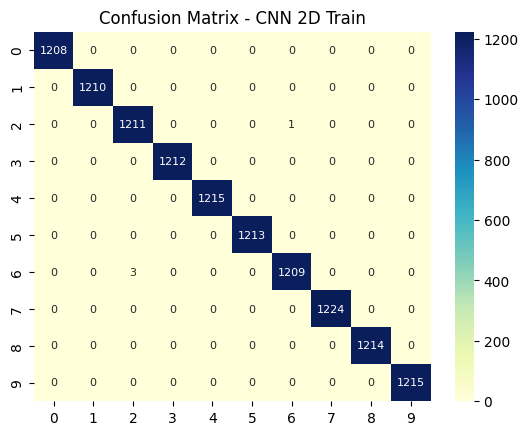

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


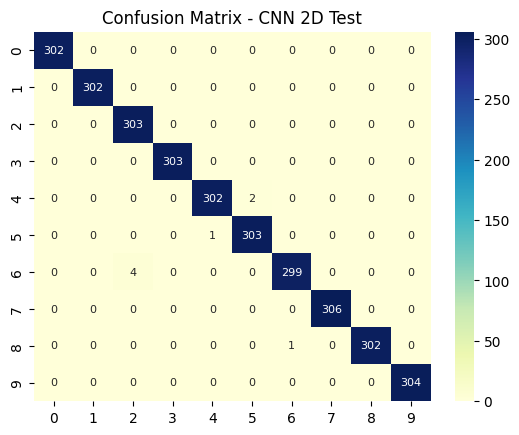

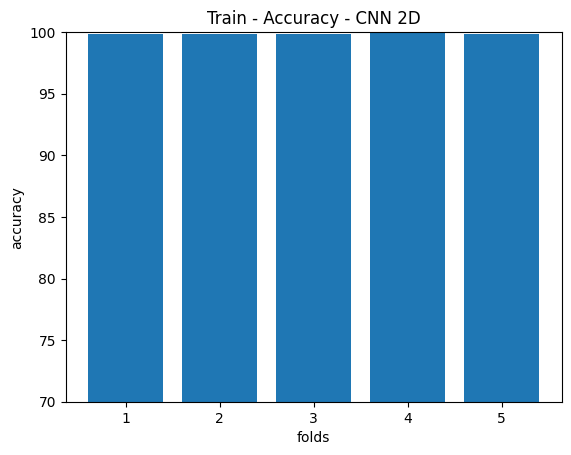

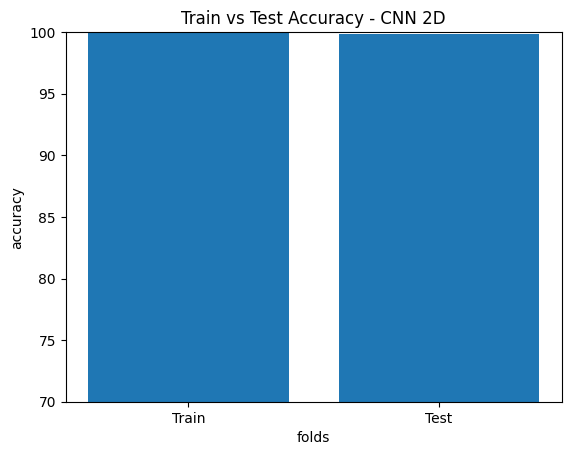

In [34]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Evaluation
# -----------------------------------------------------------------------------
"""

# Classification_2D.model.summary()

CNN_2D_train_accuracy = np.average(accuracy_train)*100
print('CNN 2D train accuracy =', CNN_2D_train_accuracy)
# print(accuracy_train)

CNN_2D_val_accuracy = np.average(accuracy_val)*100
print('CNN 2D validation accuracy =', CNN_2D_val_accuracy)
# print(accuracy_val)

CNN_2D_test_accuracy = np.average(accuracy_test)*100
print('CNN 2D test accuracy =', CNN_2D_test_accuracy)
# print(accuracy_test)

# Evaluate the accuracy of the model on the test set
# CNN_2D_test_loss, CNN_2D_test_accuracy = Classification_2D.model.evaluate(X_2D_test, y_2D_test)
# CNN_2D_test_accuracy*=100
# print('CNN 2D test accuracy =', CNN_2D_test_accuracy)


def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

# Plot results - CNN 2D
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1,2],[CNN_2D_train_accuracy,CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

In [35]:
from tensorflow.keras.models import load_model

# for i in range(1, 6):
#     filepath = f"CNN2D_results/V4_2_NOL_exp1/best_model_{i}.h5"
#     print(f"\nModel summary for fold {i}:")
#     model = load_model(filepath)
#     model.summary()
#     for i, layer in enumerate(model.layers):
#         print(f"{i}: {layer.name} — {layer.output_shape}")


filepath = f"CNN2D_results/V4_2_NOL_exp1/best_model_1.h5"
print(f"\nModel summary for fold 1:")
model = load_model(filepath)
model.summary()
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name}")


layer_name = 'dense'  # or whatever corresponds to Dense(100)
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)



Model summary for fold 1:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 40, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,014 (851.62 KB)

 Trainable params: 218,012 (851.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

0: conv2d
1: max_pooling2d
2: conv2d_1
3: max_pooling2d_1
4: conv2d_2
5: max_pooling2d_2
6: conv2d_3
7: max_pooling2d_3
8: flatten
9: dense
10: dense_1
11: dense_2
12: softmax


AttributeError: The layer sequential has never been called and thus has no defined input.

In [ ]:
# Step 1: Sample training inputs (every 10th) and get intermediate outputs
x_sampled = X_2D_train[::10]
y_sampled = y_2D_train[::10]

intermediate_outputs = intermediate_model.predict(x_sampled)

# Step 2: Reduce dimensionality using t-SNE
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(intermediate_outputs)

# Step 3: Decode one-hot labels (if needed)
from sklearn.preprocessing import LabelEncoder
if y_sampled.shape[1] > 1:
    y_label = enc.inverse_transform(y_sampled)
else:
    y_label = y_sampled.flatten()

# Step 4: Plot the results
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_embedded[:, 0], y=x_embedded[:, 1], hue=y_label, style=y_label,
                palette="bright", edgecolor='black')
plt.title("t-SNE of Intermediate CNN Layer Output (Fold 1)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
